# Exporting / Importing trained MaskRCNN model


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import numpy as np
import math

import tensorflow as tf
from tensorflow.python.framework import graph_util
from keras import backend as K

ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize
import matplotlib.pyplot as plt

%matplotlib inline 

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Importing model
Now, we can load the model from the pb file and then use it to infere

In [3]:
def mold_inputs(images,config):
    """Takes a list of images and modifies them to the format expected
    as an input to the neural network.
    images: List of image matrices [height,width,depth]. Images can have
        different sizes.

    Returns 3 Numpy matrices:
    molded_images: [N, h, w, 3]. Images resized and normalized.
    image_metas: [N, length of meta data]. Details about each image.
    windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
        original image (padding excluded).
    """
    molded_images = []
    image_metas = []
    windows = []
    for image in images:
        # Resize image
        # TODO: move resizing to mold_image()
        molded_image, window, scale, padding, crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            min_scale=config.IMAGE_MIN_SCALE,
            max_dim=config.IMAGE_MAX_DIM,
            mode=config.IMAGE_RESIZE_MODE)
        molded_image = mold_image(molded_image, config)
        # Build image_meta
        image_meta = compose_image_meta(
            0, image.shape, molded_image.shape, window, scale,
            np.zeros([config.NUM_CLASSES], dtype=np.int32))
        # Append
        molded_images.append(molded_image)
        windows.append(window)
        image_metas.append(image_meta)
    # Pack into arrays
    molded_images = np.stack(molded_images)
    image_metas = np.stack(image_metas)
    windows = np.stack(windows)
    return molded_images, image_metas, windows

def mold_image(images, config):
    return images.astype(np.float32) - config.MEAN_PIXEL

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

def unmold_detections(detections, mrcnn_mask, image_shape, window):
    """Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the
    application.

    detections: [N, (y1, x1, y2, x2, class_id, score)]
    mrcnn_mask: [N, height, width, num_classes]
    image_shape: [height, width, depth] Original size of the image before resizing
    window: [y1, x1, y2, x2] Box in the image where the real image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]
    print('Number of detections: ',N)
    print('Window: ',window)
    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    print('boxes',boxes.shape,' ',boxes)
    class_ids = detections[:N, 4].astype(np.int32)
    print('Class_ids: ',class_ids.shape,' ',class_ids)
    scores = detections[:N, 5]
    print('Scores: ',scores.shape,' ',scores)
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]
    print('Masks: ',masks.shape)# masks)
    # Compute scale and shift to translate coordinates to image domain.
    print(image_shape[0])
    print(window[2] - window[0])
    h_scale = image_shape[0] / (window[2] - window[0])
    print('h_scale: ',h_scale)
    w_scale = image_shape[1] / (window[3] - window[1])
    print('w_scale: ',w_scale)
    scale = min(h_scale, w_scale)
    shift = window[:2]  # y, x
    print('shift: ',shift)
    scales = np.array([scale, scale, scale, scale])
    print('scales: ',scales)
    shifts = np.array([shift[0], shift[1], shift[0], shift[1]])
    print('shifts: ',shifts)
    # Translate bounding boxes to image domain
    boxes = np.multiply(boxes - shifts, scales).astype(np.int32)
    print('boxes: ',boxes.shape,' ',boxes)
    # Filter out detections with zero area. Often only happens in early
    # stages of training when the network weights are still a bit random.
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
    if exclude_ix.shape[0] > 0:
        boxes = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores = np.delete(scores, exclude_ix, axis=0)
        masks = np.delete(masks, exclude_ix, axis=0)
        N = class_ids.shape[0]

    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = utils.unmold_mask(masks[i], boxes[i], image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty((0,) + masks.shape[1:3])

    return boxes, class_ids, scores, full_masks

def get_anchors(image_shape, config):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(config, image_shape)
    # Cache anchors and reuse if image shape is the same
    _anchor_cache = {}
    if not tuple(image_shape) in _anchor_cache:
        # Generate Anchors
        a = utils.generate_pyramid_anchors(
            config.RPN_ANCHOR_SCALES,
            config.RPN_ANCHOR_RATIOS,
            backbone_shapes,
            config.BACKBONE_STRIDES,
            config.RPN_ANCHOR_STRIDE)
        # Keep a copy of the latest anchors in pixel coordinates because
        # it's used in inspect_model notebooks.
        # TODO: Remove this after the notebook are refactored to not use it
        anchors = a
        # Normalize coordinates
        _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

In [4]:
import nova_basic

class inferNovaConfig(nova_basic.novaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = inferNovaConfig()

Loading data from ../data/sample
Loading eval data
Loaded 20 images from ['eval'] data.


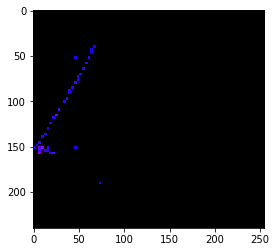

In [5]:
dataset = nova_basic.novaDataset()
dataset.load_nova('../data/sample','eval')
dataset.prepare()

image=dataset.load_image(0)
images = [image]
plt.imshow(image)

In [6]:
sess = tf.InteractiveSession()

In [9]:
with tf.gfile.FastGFile('../model.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
print('Graph loaded.')

print("Processing {} images".format(len(images)))
for im in images:
    modellib.log("image", im)
print('RGB image loaded and preprocessed.')
molded_images, image_metas, windows = mold_inputs(images, config)
print(molded_images.shape)

image_shape = molded_images[0].shape
anchors = get_anchors(image_shape, config)
image_anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

print('Images meta: ',image_metas)
img_ph = sess.graph.get_tensor_by_name('input_image:0')
print(img_ph)
img_anchors_ph = sess.graph.get_tensor_by_name('input_anchors:0')
print(img_anchors_ph)
img_meta_ph = sess.graph.get_tensor_by_name('input_image_meta:0')
print(img_meta_ph)
detectionsT = sess.graph.get_tensor_by_name('output_detections:0')
print('Found ',detectionsT)
mrcnn_classT = sess.graph.get_tensor_by_name('output_mrcnn_class:0')
print('Found ',mrcnn_classT)
mrcnn_bboxT = sess.graph.get_tensor_by_name('output_mrcnn_bbox:0')
print('Found ', mrcnn_bboxT)
mrcnn_maskT = sess.graph.get_tensor_by_name('output_mrcnn_mask:0')
print('Found ', mrcnn_maskT)
roisT = sess.graph.get_tensor_by_name('output_rois:0')
print('Found ', roisT)

detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rois = \
    sess.run([detectionsT, mrcnn_classT, mrcnn_bboxT, mrcnn_maskT, roisT],
        feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
'''
detections = sess.run(detectionsT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})
#print('Detections: ',detections[0].shape, detections[0])
mrcnn_class = sess.run(mrcnn_classT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})
#print('Classes: ',mrcnn_class[0].shape, mrcnn_class[0])
mrcnn_bbox = sess.run(mrcnn_bboxT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})
#print('BBoxes: ',mrcnn_bbox[0].shape, mrcnn_bbox[0])
mrcnn_mask = sess.run(mrcnn_maskT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})
#print('Masks: ',mrcnn_mask[0].shape )#, outputs1[0])
rois = sess.run(roisT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})
#print('Rois: ',rois[0].shape, rois[0])

results = []
for i, image in enumerate(images):
    print('Calculating results for image#',i)
    final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[i], mrcnn_mask[i],
                                    image.shape, windows[i])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })
r = results[0]
#print(r)
print (r['scores'][0])
print (r['class_ids'][0])
print (r['rois'][0])
print (r['masks'][0].shape)

class_names = ["BG","nuclei"]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=get_ax())
print('Done')
'''

Graph loaded.
Processing 1 images
image                    shape: (240, 255, 3)         min:    0.00000  max:  255.00000  uint8
RGB image loaded and preprocessed.
(1, 256, 256, 3)
Images meta:  [[  0 240 255   3 256 256   3   8   0 248 255   1   0   0   0   0   0   0
    0]]
Tensor("input_image:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("input_anchors:0", shape=(?, ?, 4), dtype=float32)
Tensor("input_image_meta:0", shape=(?, 19), dtype=float32)
Found  Tensor("output_detections:0", shape=(1, 100, 6), dtype=float32)
Found  Tensor("output_mrcnn_class:0", shape=(?, 1000, 7), dtype=float32)
Found  Tensor("output_mrcnn_bbox:0", shape=(?, 1000, 7, 4), dtype=float32)
Found  Tensor("output_mrcnn_mask:0", shape=(?, 100, 28, 28, 7), dtype=float32)
Found  Tensor("output_rois:0", shape=(1, ?, ?), dtype=float32)


'\ndetections = sess.run(detectionsT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})\n#print(\'Detections: \',detections[0].shape, detections[0])\nmrcnn_class = sess.run(mrcnn_classT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})\n#print(\'Classes: \',mrcnn_class[0].shape, mrcnn_class[0])\nmrcnn_bbox = sess.run(mrcnn_bboxT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})\n#print(\'BBoxes: \',mrcnn_bbox[0].shape, mrcnn_bbox[0])\nmrcnn_mask = sess.run(mrcnn_maskT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})\n#print(\'Masks: \',mrcnn_mask[0].shape )#, outputs1[0])\nrois = sess.run(roisT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas})\n#print(\'Rois: \',rois[0].shape, rois[0])\n\nresults = []\nfor i, image in enumerate(images):\n    print(\'Calculating results for image#\',i)\n    final_rois, final_class_ids, final_scores, final_masks =    unmold_detections(detections[i], mrcnn_mask[i],\n                              

In [10]:
print(detections.shape)
print(mrcnn_class.shape)
print(mrcnn_bbox.shape)
print(mrcnn_mask.shape)
print(rois.shape)

(1, 100, 6)
(1, 1000, 7)
(1, 1000, 7, 4)
(1, 100, 28, 28, 7)
(1, 1000, 4)


In [65]:
mrcnn_class[0][11]

array([2.9232206e-03, 2.1767330e-03, 9.7380316e-01, 2.0304220e-03,
       9.7126508e-04, 1.7662117e-02, 4.3310277e-04], dtype=float32)

In [63]:
detections[0][0]

array([0.19620506, 0.01870974, 0.6036592 , 0.26337546, 2.        ,
       0.97380316], dtype=float32)

In [23]:
rois[0][0]

array([0.19545679, 0.02805722, 0.5970976 , 0.26454562], dtype=float32)

In [29]:
mrcnn_bbox[0][0]

array([[-1.3239254 ,  0.06280455, -0.10303418,  0.33728734],
       [ 0.1408026 , -0.28707498,  0.2026481 ,  0.23306167],
       [ 0.02454042, -0.14768033,  0.10552421,  0.30594844],
       [ 0.23926234, -0.06561389, -0.3906288 , -0.34427735],
       [-0.46545222,  0.18579829, -0.4898569 , -0.6205792 ],
       [ 0.12163846, -0.2983503 , -0.28613093, -0.02090784],
       [ 0.2647211 , -0.12588654, -0.10868292,  0.24211803]],
      dtype=float32)

In [33]:
mrcnn_mask[0][0]

array([[[3.41673911e-01, 2.09830559e-05, 7.89885326e-06, ...,
         1.80612224e-05, 1.89063339e-05, 6.68492430e-05],
        [1.38529420e-01, 6.51002574e-06, 1.05241850e-06, ...,
         2.13068301e-06, 1.38524297e-06, 4.45478008e-06],
        [2.15829849e-01, 3.95630515e-08, 1.49000670e-08, ...,
         3.62769264e-08, 3.29295560e-08, 2.25161230e-07],
        ...,
        [3.24926972e-01, 5.53620122e-02, 5.71050718e-02, ...,
         4.45431992e-02, 6.55668303e-02, 6.03360981e-02],
        [5.23662210e-01, 2.49404952e-01, 2.23479629e-01, ...,
         2.01233879e-01, 2.64688402e-01, 2.15894029e-01],
        [3.71213555e-01, 1.32080317e-01, 1.51684433e-01, ...,
         1.17888048e-01, 1.59972534e-01, 1.37254700e-01]],

       [[6.13143325e-01, 4.43234558e-06, 9.97602228e-07, ...,
         1.03272953e-06, 5.87859677e-06, 5.18195793e-06],
        [9.12425637e-01, 3.99717010e-07, 7.01528364e-08, ...,
         1.15577130e-07, 1.97388587e-07, 2.02472438e-06],
        [5.79440594e-01, 